# Project - UNet
This file contains the process of training and calculating IoU of UNet with resnet34 as backnbone. The main procedure is following what we have in Deeplabv3.

###  1.Create data dictionary by train, valid and test

In [1]:
import pandas as pd
import os

In [2]:
# Load metadata splits using your local route
meta_split = pd.read_csv('data/metadata_splits.csv')  # Adjusted path for your project folder

# Extract main data columns
meta_data = meta_split[['id', 'file_name', 'split_open']]

# Get unique data types (train, valid, test)
data_type = set(meta_data['split_open'])

# Create a dictionary to hold data for each type
meta_data_dict = {}
for type in data_type:
    meta_data_dict[type] = []

# Populate the dictionary with IDs and file names based on data type
for index, row in meta_data.iterrows():
    meta_data_dict[row['split_open']].append((row['id'], row['file_name']))

# Print the number of images in each set
print(f"train set number: {len(meta_data_dict['train'])}")
print(f"valid set number: {len(meta_data_dict['valid'])}")
print(f"test set number: {len(meta_data_dict['test'])}")

# Display the main metadata dataframe
meta_data


train set number: 5303
valid set number: 1118
test set number: 2308


,id,file_name,split_open
0,1,images/t001/CAluWEgwPX.JPG,train
1,2,images/t001/EKyrFKHQzh.JPG,train
2,3,images/t001/ELAvEqeXxT.JPG,train
3,4,images/t001/IxRLFwTGCv.JPG,train
4,5,images/t001/LKCJAhfLBJ.JPG,train
...,...,...,...
8724,8725,images/t610/miUGGSioXO.jpeg,test
8725,8726,images/t610/aOzTdMCkzF.jpeg,test
8726,8727,images/t610/ZmTLXySHIZ.jpeg,test
8727,8728,images/t610/qVDYBLbzda.jpeg,test


### 2.Set class dataset by using coco

for getting image and mask, then we can put into model

In [3]:
import json
from pycocotools.coco import COCO
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models.segmentation
import torch.optim as optim 
import torch

In [4]:
# set img dir
image_dir = 'data/images'

# json to coco
coco = COCO('data/annotations.json')

# image and mask transform method
transform_method = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

target_transform_method = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST), 
    transforms.Lambda(lambda mask: torch.from_numpy(np.array(mask)).long())
])

loading annotations into memory...
Done (t=4.63s)
creating index...
index created!


In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, coco, meta_data_dict, data_type, transform=None, target_transform=None):
        self.image_dir = image_dir  # original image dir
        self.coco = coco # coco
        self.data_type = data_type # train valid test
        self.transform = transform  # transform method
        self.target_transform = target_transform  # transform method
        self.images = [] # all original images path in train set

        data_list = meta_data_dict[self.data_type]
        img_Ids = self.coco.getImgIds()

        for i in img_Ids:
            # if img_id in data_type list is true
            if any(t[0] == i for t in data_list):
                self.images.append(self.coco.loadImgs(i)[0])

    def process_mask(self, image_id, image):
        category_map = {
            1: 1,  # turtles
            2: 2,  # flipper
            3: 3   # head
        }
        
        mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        for cat_id, target_value in category_map.items():
            ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=cat_id, iscrowd=None)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                ann_mask = self.coco.annToMask(ann)
                mask[ann_mask > 0] = target_value  
                
        return mask

    def __len__(self):  # set dataset size
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        # Get image ID
        img_id = img['id']
        # Get image file name
        img_file_name = img['file_name']

        # Construct the full image path
        if img_file_name.startswith('images/'):  # Check if the path already includes 'images'
            image_path = os.path.join(self.image_dir, img_file_name.split('images/', 1)[-1])
        else:
            image_path = os.path.join(self.image_dir, img_file_name)

        # Load the image and convert to RGB
        image = Image.open(image_path).convert("RGB")
        
        # Process the mask
        mask = self.process_mask(img_id, image)
        mask = Image.fromarray(mask.astype('uint8'))  # Convert to PIL image

        # Transform the image and mask to [C, H, W]
        image = self.transform(image)
        mask = self.target_transform(mask)

        return image, mask




    
    # image: PIL [H,W,C] -> [C,H,W]
    # mask: numpy -> PIL [H,W,C] -> [C,H,W]


### 3.Create dataset for train, valid, test

In [6]:
# create train dateset
train_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='train'
)

# create valid dataset
valid_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='valid'
)

# create test dataset
test_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='test'
)

### 4.Create dataloader
divide dataset into samll dataset in order to improving effiency

In [7]:
# create valid DataLoader
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
# create test DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
# create train DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# see the data set size
for images, masks in train_dataloader:
    print("Batch of images:", images.shape)  # show the first image tensor
    print("Batch of masks:", masks.shape)    # show the first mask tensor
    unique_values = torch.unique(masks)     
    print("Masks dtype:", masks.dtype)      # show the first mask dtype
    print("Masks value:", unique_values)    # show the first mask uniqe
    break  # just want to the first one


Batch of images: torch.Size([8, 3, 512, 512])
Batch of masks: torch.Size([8, 512, 512])
Masks dtype: torch.int64
Masks value: tensor([0, 1, 2, 3])


### 5.Show dataloader size and dataset size

In [15]:
print("Total number of images in the dataset:", len(train_dataset))
print("Total number of images in the dataset:", len(valid_dataset))
print("Total number of images in the dataset:", len(test_dataset))
print("Total number of images in the dataset:", len(train_dataloader))
print("Total number of images in the dataset:", len(test_dataloader))

Total number of images in the dataset: 5303
Total number of images in the dataset: 1118
Total number of images in the dataset: 2308
Total number of images in the dataset: 332
Total number of images in the dataset: 577


In [9]:
# Check if PyTorch recognizes the GPU
print("Is CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


Is CUDA available: True
Device name: NVIDIA GeForce RTX 4070 Ti


### Half the training data

In [10]:
from torch.utils.data import random_split

train_size = int(0.5 * len(train_dataset))
train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])

train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=8, shuffle=True)


### 6.Using UNet model to get iou and miou

In [ ]:
from segmentation_models_pytorch import Unet
num_classes = 4

# UNet
model = Unet('resnet34', classes=num_classes, activation=None, encoder_weights=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 25

In [12]:
# caculate iou function
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    pred_mask = pred_mask.view(-1)  
    true_mask = true_mask.view(-1)  

    for cls in range(1, num_classes):  # only caculate iou for three classes
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        
        intersection = (pred_inds & true_inds).sum().float()  
        union = (pred_inds | true_inds).sum().float()  

        if union == 0:
            ious.append(float('nan'))  # avoid denominators of zero
        else:
            ious.append((intersection / union).item())  # append iou in list

    return ious # return list

In [17]:
# Directory to save the model weights
os.makedirs('./saved_models', exist_ok=True)
save_path = './saved_models/unet_model_epoch{}.pth'

# ----------------------
# Training Phase
# ----------------------
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Save model weights at the end of each epoch
    torch.save(model.state_dict(), save_path.format(epoch + 1))
    print(f"Model weights saved for epoch {epoch + 1} at {save_path.format(epoch + 1)}")

    # ----------------------
    # Validation Phase
    # ----------------------
    model.eval()  # Set model to evaluation mode
    all_ious = []  # Record all IoUs in one epoch

    with torch.no_grad():  # No gradient computation
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1)

            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                ious = calculate_iou(pred_masks[i], masks[i], num_classes=num_classes)
                all_ious.append(ious)

    # Calculate mIoU and average of total mIoU
    all_ious_tensor = torch.tensor(all_ious)
    mean_ious = torch.nanmean(all_ious_tensor, dim=0)
    avg_all_mious = torch.nanmean(mean_ious).item()

    # Print validation results
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation mIoU: {avg_all_mious:.4f}")
    for cls in range(num_classes):
        if cls == 0:
            print(f" - Class {cls + 1} 'turtle' mIoU: {mean_ious[cls].item():.4f}")
        elif cls == 1:
            print(f" - Class {cls + 1} 'flipper' mIoU: {mean_ious[cls].item():.4f}")
        elif cls == 2:
            print(f" - Class {cls + 1} 'head' mIoU: {mean_ious[cls].item():.4f}")

    print("----------------------------------------------------------------")

# ----------------------
# Testing Phase
# ----------------------
model.eval()
test_ious = []

with torch.no_grad():
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)

        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            ious = calculate_iou(pred_masks[i], masks[i], num_classes=num_classes)
            test_ious.append(ious)

# Calculate mIoU and average of total mIoU for testing
all_ious_tensor = torch.tensor(test_ious)
mean_ious = torch.nanmean(all_ious_tensor, dim=0)
avg_all_mious = torch.nanmean(mean_ious).item()

# Print test results
print(f"Testing the average of three class mIoU: {avg_all_mious:.4f}")
for cls in range(num_classes):
    if cls == 0:
        print(f" - Class {cls + 1} 'turtle' mIoU: {mean_ious[cls].item():.4f}")
    elif cls == 1:
        print(f" - Class {cls + 1} 'flipper' mIoU: {mean_ious[cls].item():.4f}")
    elif cls == 2:
        print(f" - Class {cls + 1} 'head' mIoU: {mean_ious[cls].item():.4f}")



Epoch [1/25], Training Loss: 0.4966
Model weights saved for epoch 1 at ./saved_models/unet_model_epoch1.pth
Epoch [1/25], Validation mIoU: 0.6912
 - Class 1 'turtle' mIoU: 0.8068
 - Class 2 'flipper' mIoU: 0.6400
 - Class 3 'head' mIoU: 0.6269
----------------------------------------------------------------
Epoch [2/25], Training Loss: 0.1144
Model weights saved for epoch 2 at ./saved_models/unet_model_epoch2.pth
Epoch [2/25], Validation mIoU: 0.7490
 - Class 1 'turtle' mIoU: 0.8569
 - Class 2 'flipper' mIoU: 0.6894
 - Class 3 'head' mIoU: 0.7007
----------------------------------------------------------------
Epoch [3/25], Training Loss: 0.0520
Model weights saved for epoch 3 at ./saved_models/unet_model_epoch3.pth
Epoch [3/25], Validation mIoU: 0.7897
 - Class 1 'turtle' mIoU: 0.8730
 - Class 2 'flipper' mIoU: 0.7542
 - Class 3 'head' mIoU: 0.7418
----------------------------------------------------------------
Epoch [4/25], Training Loss: 0.0362
Model weights saved for epoch 4 at ./

### 7 Get visualised results for some correctly predicted and incorrectly predicted samples

In [22]:
import random

def load_model(model_path, device, model_class, *model_args, **model_kwargs):
    """
    Load the model with given class and parameters, and load the state dictionary.
    """
    # Initialize the model
    model = model_class(*model_args, **model_kwargs).to(device)
    
    # Load the state dictionary
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()  # Set model to evaluation mode
    return model

def visualize_results(image, true_mask, pred_mask, save_path=None, title=None):
    """
    Visualize the original image, true mask, and predicted mask.
    Optionally save the visualization to a file.
    """
    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
    true_mask_np = true_mask.cpu().numpy()
    pred_mask_np = pred_mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax, img, t in zip(axs, [image_np, true_mask_np, pred_mask_np], ["Original Image", "True Mask", "Predicted Mask"]):
        ax.imshow(img)
        ax.set_title(t)
        ax.axis("off")

    if title:
        fig.suptitle(title, fontsize=16)

    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    else:
        plt.show()



def get_top_bottom_indices(dataloader, model, device, num_classes, top_n=5, bottom_n=5):
    """
    Evaluate the test set, calculate IoU for each sample, and return indices of top and bottom predictions.
    """
    iou_scores = []
    sample_indices = []

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)

            # Perform inference
            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)

            # Calculate IoU for each sample in the batch
            for i in range(images.size(0)):
                ious = calculate_iou(pred_masks[i].cpu(), masks[i].cpu(), num_classes)
                avg_iou = torch.nanmean(torch.tensor(ious))

                # Store IoU score and sample index
                iou_scores.append(avg_iou)
                sample_indices.append(batch_idx * dataloader.batch_size + i)

    # Sort indices by IoU scores
    sorted_indices = sorted(range(len(iou_scores)), key=lambda x: iou_scores[x], reverse=True)

    # Extract top and bottom indices
    top_indices = [sample_indices[i] for i in sorted_indices[:top_n]]
    bottom_indices = [sample_indices[i] for i in sorted_indices[-bottom_n:]]

    return top_indices, bottom_indices

def visualize_selected_samples(dataset, dataloader, model, device, selected_indices, num_classes, save_prefix):
    """
    Visualize the selected samples (top or bottom IoU) based on their indices.
    """
    model.eval()

    for idx, sample_index in enumerate(selected_indices):
        # Fetch the specific sample
        image, true_mask = dataset[sample_index]
        image = image.to(device).unsqueeze(0)  # Add batch dimension
        true_mask = true_mask.to(device)

        # Perform inference
        with torch.no_grad():
            output = model(image)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu()

        # Visualize
        visualize_results(
            image.squeeze(0).cpu(),
            true_mask.cpu(),
            pred_mask,
            save_path=f"./results/{save_prefix}_sample_{idx}.png",
            title=f"{save_prefix.capitalize()} Prediction (Index={sample_index})"
        )


C:\Users\andyw\AppData\Local\Temp\ipykernel_3512\3899203448.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Visualization saved to ./results/top_sample_0.png
Visualization saved to ./results/top_sample_1.png
Visualization saved to ./results/top_sample_2.png
Visualization saved to ./results/top_sample_3.png
Visualization saved to ./results/top_sample_4.png
Visualization saved to ./results/bottom_sample_0.png
Visualization saved to ./results/bottom_sample_1.png
Visualization saved to ./results/bottom_sample_2.png
Visualization saved to ./results/bottom_sample_3.png
Visualization saved to ./results/bottom_sample_4.png


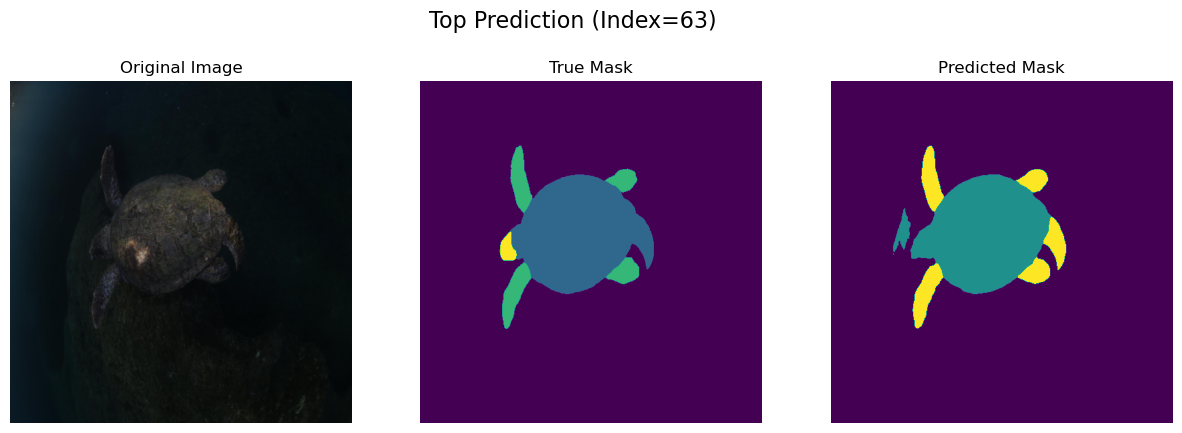

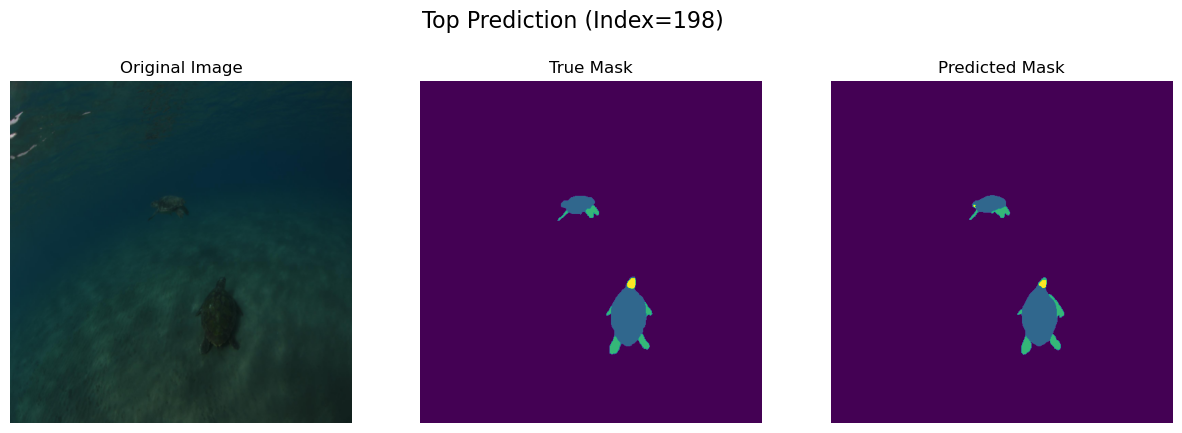

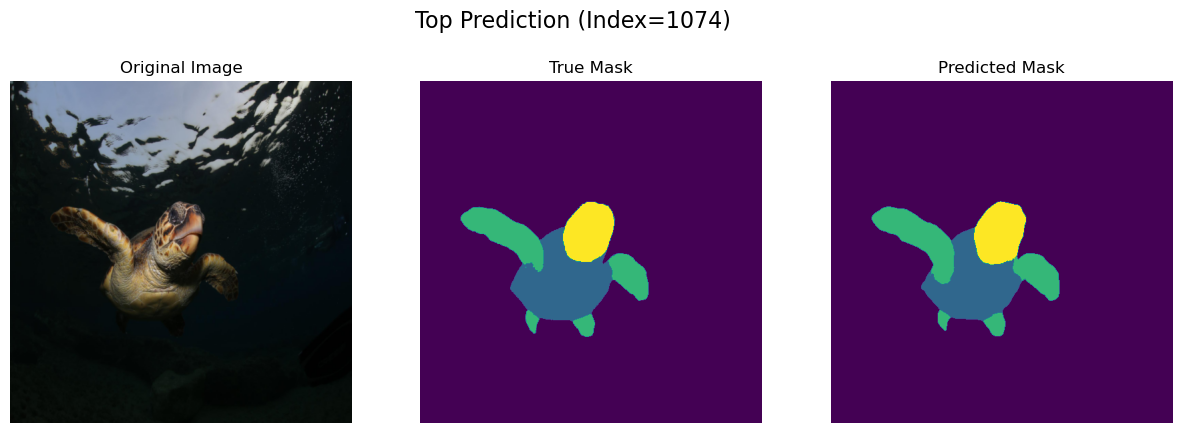

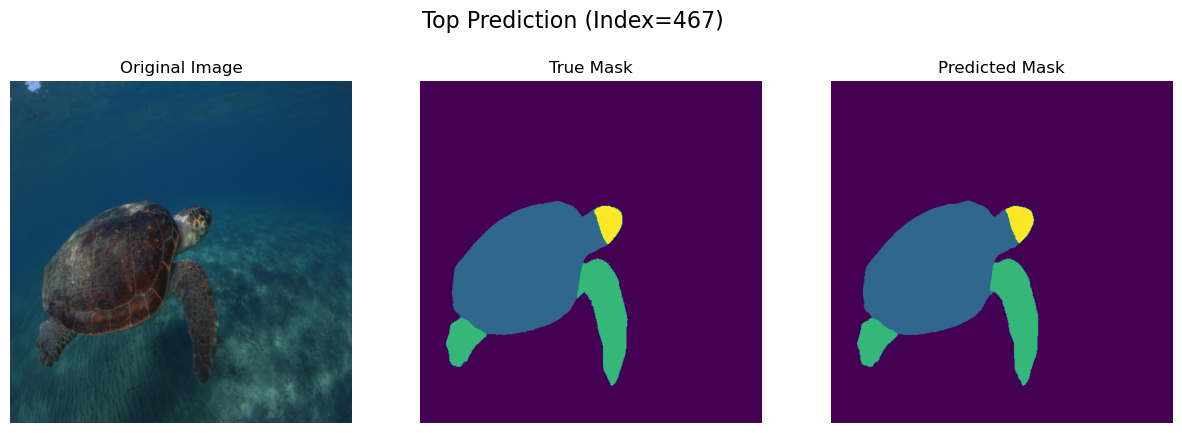

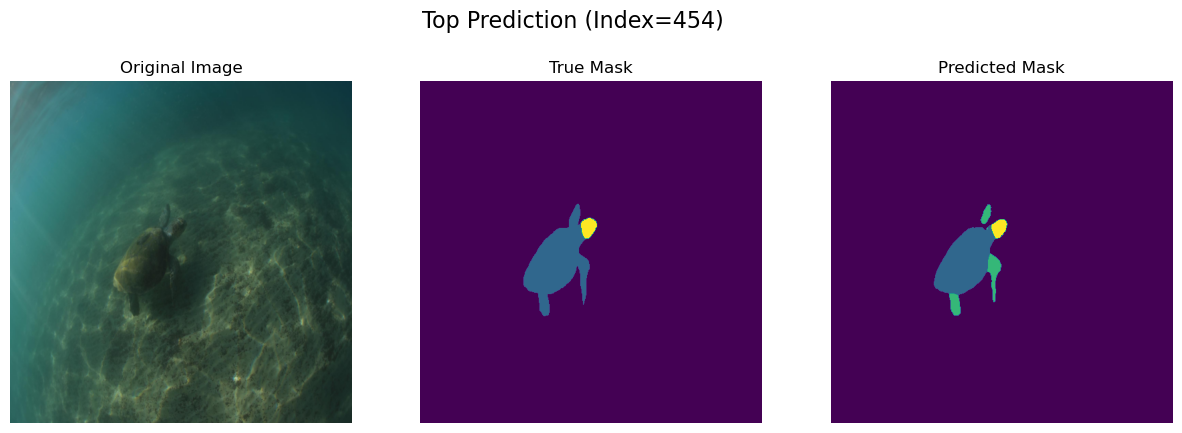

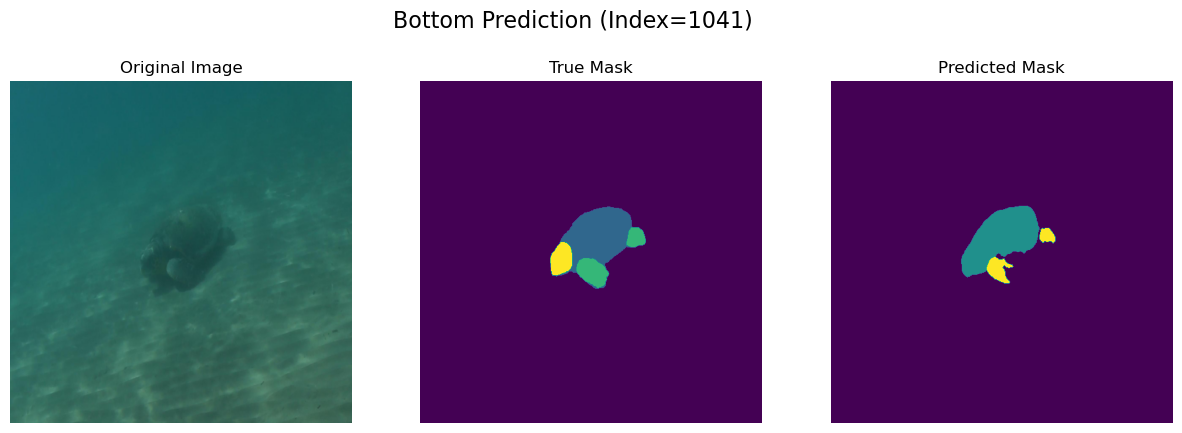

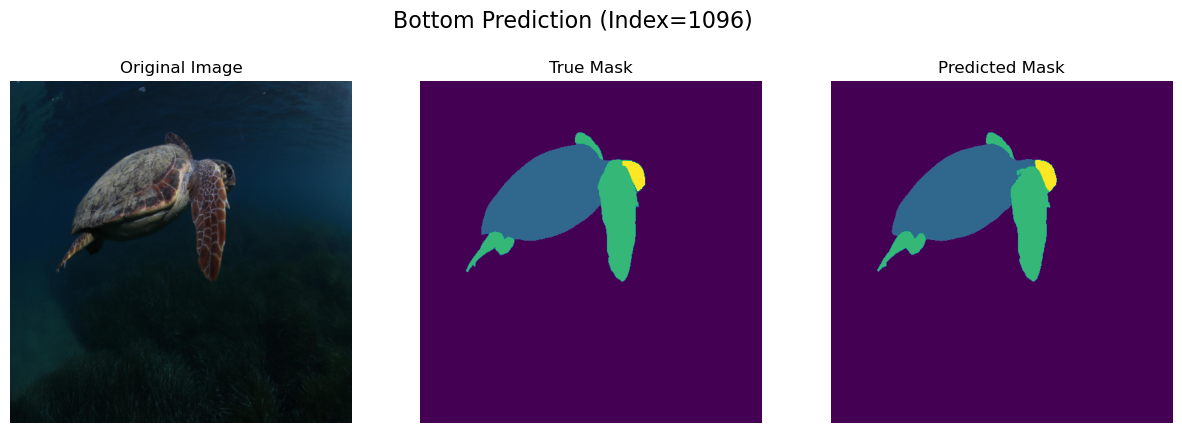

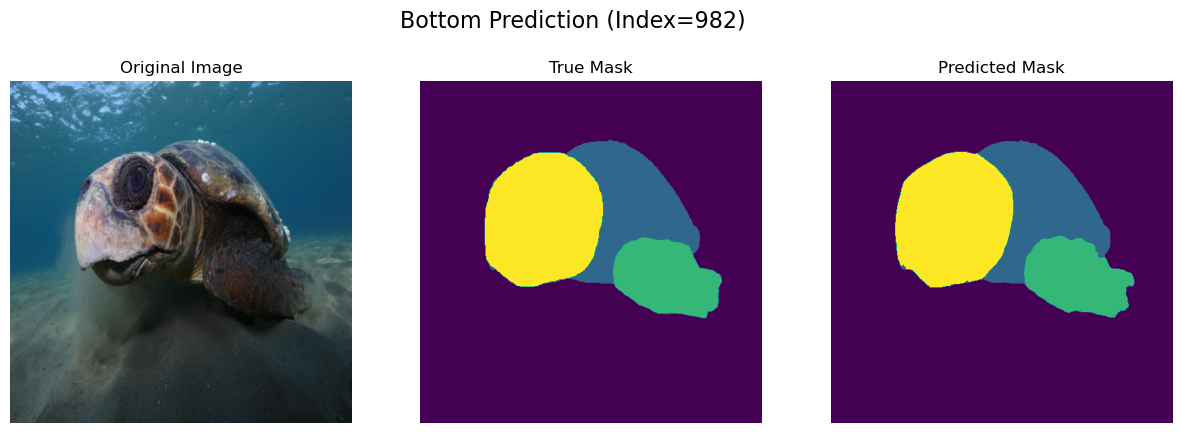

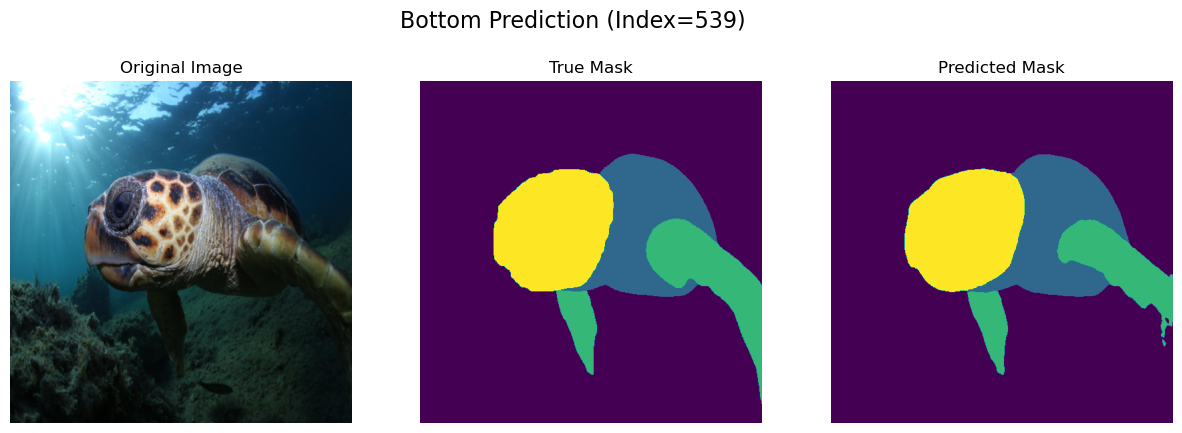

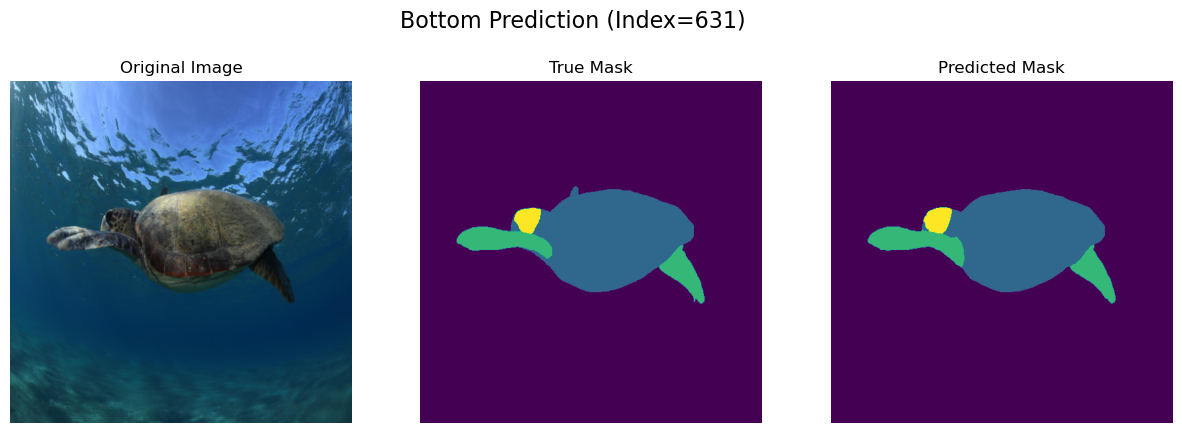

In [24]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = load_model(
    model_path='./saved_models/unet_model_epoch25.pth',
    device=device,
    model_class=Unet,
    encoder_name="resnet34",  # Specify encoder backbone
    in_channels=3,           # Number of input channels (e.g., RGB)
    classes=4                # Number of output classes
)

# Define the number of classes (e.g., background, turtle, flipper, head)
num_classes = 4

# Get indices of top 5 and bottom 5 predictions
top_indices, bottom_indices = get_top_bottom_indices(
    dataloader=test_dataloader,
    model=model,
    device=device,
    num_classes=num_classes,
    top_n=5,
    bottom_n=5
)

# Visualize top 5 predictions
visualize_selected_samples(
    dataset=test_dataset,
    dataloader=test_dataloader,
    model=model,
    device=device,
    selected_indices=top_indices,
    num_classes=num_classes,
    save_prefix="top"
)

# Visualize bottom 5 predictions
visualize_selected_samples(
    dataset=test_dataset,
    dataloader=test_dataloader,
    model=model,
    device=device,
    selected_indices=bottom_indices,
    num_classes=num_classes,
    save_prefix="bottom"
)
